<a href="https://colab.research.google.com/github/fchantrel/notebooks_ml/blob/main/Part_2_DL_Models_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Firstly, we will install the basic libraries for coding in Python3.

for kernel running on macOS, install locally: brew install gfortran

In [ ]:
!pip3 install --upgrade pip
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib
!pip3 install scikit-learn
!pip3 install keras

     |████████████████████████████████| 1.7 MB 5.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


# Part 2 - Deep Learning Models for forecasting

# Mackey Glass (Time-Series Dataset #2)

## 2.1 Data preprocessing and creation of datasets for supervised learning


For reproducing our code and getting the same results for comparisons, especially while training neural networks, we need to set the random seeds for numpy library and keras. We will use the following code for a first initialization ([numpy.random.seed](https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html), [tensorflow.random.set_seed](https://www.tensorflow.org/api_docs/python/tf/random/set_seed)). We will run again these instructions before training a new model together with [keras.backend.clear_session](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os

import tensorflow as tf
import keras
from keras.models import Input, Sequential, load_model, Model
from keras.layers import Dense, LSTM, Dropout
from keras.layers import Conv1D, Flatten, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

from numpy.random import seed
seed(100)
tf.random.set_seed(100)

### 2.1.1 Load and Visualize Data

The **Mackey-Glass** equation is the nonlinear time delay differential equation
$$ \frac{dy}{dt} = c \frac{y_{t-\tau}}{1+y_{t-\tau}^n}-b y(t)$$$$c,b,n>0$$
where $c, \tau, b, n$ real numbers and $y_{t-\tau}$ represents the value of the variable $y$ at time $t-\tau$. Depending on the values of the parameters, this equation displays a range of periodic and chaotic
dynamics. The behaviour of these equations manages to mimic both healthy and pathological behaviour in certain biological contexts.

The function create_mackey_glass_dataset() takes as input the number $N$ of the desired time-steps and returns a time-series based on the mackey-glass equation.

*Your task is load to the dataset into a pandas after calling the function create_mackey_glass_dataset() and print it.*

In [ ]:
def create_mackey_glass_dataset(N = 2000):
    b   = 0.1
    c   = 0.2
    tau = 17

    y = [0.9697, 0.9699, 0.9794, 1.0003, 1.0319, 1.0703, 1.1076, 1.1352, 1.1485,
         1.1482, 1.1383, 1.1234, 1.1072, 1.0928, 1.0820, 1.0756, 1.0739, 1.0759]

    for n in range(17,N+99):
        y.append(y[n] - b*y[n] + c*y[n-tau]/(1+y[n-tau]**10))
    y = y[100:]
    return y

In [ ]:
# Fill your code here
# load series into a pandas dataframe using create_mackey_glass_dataset()
y = create_mackey_glass_dataset()
df = pd.DataFrame(y,columns=['Mackey-glass'])
df

,Mackey-glass
0,0.933143
1,0.917522
2,0.902385
3,0.890816
4,0.886532
...,...
1995,0.612803
1996,0.608896
1997,0.620557
1998,0.650573


Next, we can visualize the evolution of the series over time.

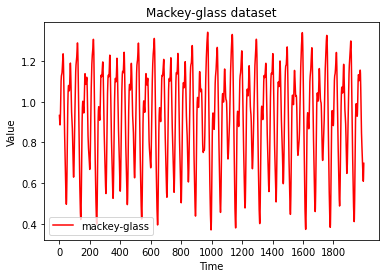

In [ ]:
# Plot time series from pandas
plt.plot(df['Mackey-glass'], color = 'red', label = 'mackey-glass')
plt.xticks(np.arange(0,len(df),200))
plt.title('Mackey-glass dataset')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### 2.1.2 Feature Selection & Train, Test split 

We define a function ***split_data*** for splitting our initial pandas to 3 different pandas to create our train, validation and test sets. The function split_data keeps the first 80% of time-steps for train, the next 10% for validation and the last 10% for test. No overlapping exists between the 3 respective pandas and the order of time-steps is maintained. 

In [ ]:
# The function below receives a pandas dataframe (df) 
# and creates 3 different dataframes for train, validation, test sets with respect to the order of time-steps
# Input: df - the initial pandas.dataframe
# Output: df_train (first 80% of the time series), df_val (next 10%), df_test (final 10%)

def split_data(df):
    times = sorted(df.index.values)
    last_10pct = sorted(df.index.values)[-int(0.1*len(times))]  # Last 10% of series
    last_20pct = sorted(df.index.values)[-int(0.2*len(times))]  # Last 20% of series
    
    df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
    df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
    df_test = df[(df.index >= last_10pct)]

    return df_train, df_val, df_test

Before applying ***split_data*** to our data, we select the different feature columns on which we will train our model, by defining a list of columns' names. Here we have only 1 column since the tim series is univariate.

*Your task is to split the dataset into train, validation and test sets using split_data() and print their shapes.*

In [ ]:
# Define the features that will be used for training
train_columns = ['Mackey-glass']

# Fill your code here
# Get only the train_columns part of pandas 
# Call split_data function  and print the shape of each set
df_train, df_val, df_test = split_data(df[train_columns])
print('Train \n', df_train)
print('Val \n', df_val)
print('Test \n', df_test)

Train 
       Mackey-glass
0         0.933143
1         0.917522
2         0.902385
3         0.890816
4         0.886532
...            ...
1595      1.341314
1596      1.339445
1597      1.323542
1598      1.291010
1599      1.243828

[1600 rows x 1 columns]
Val 
       Mackey-glass
1600      1.186463
1601      1.123312
1602      1.057647
1603      0.991623
1604      0.926606
...            ...
1795      0.925546
1796      0.909715
1797      0.895117
1798      0.885010
1799      0.883189

[200 rows x 1 columns]
Test 
       Mackey-glass
1800      0.893208
1801      0.917017
1802      0.953603
1803      0.998169
1804      1.042832
...            ...
1995      0.612803
1996      0.608896
1997      0.620557
1998      0.650573
1999      0.697330

[200 rows x 1 columns]


### 2.1.3 Scaling with MinMaxScaler

After turning pandas to arrays, we apply scaling to train, validation and test sets. 

We select the [Min-Max Scaler from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), which is defined as follows for the feature $X$:
$$X_{std} = \frac{(X - X.min)}{(X.max - X.min)}$$
$$X_{scaled} = X_{std} * (max - min) + min$$ where (min, max) is the new feature range.
This estimator scales and translates each feature individually so that it is in the given range on the training set, e.g. between zero and one.

In [ ]:
# Transform pandas to numpy arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values

print('Train data has shape', np.shape(train_data))
print('Validation data has shape', np.shape(val_data))
print('Test data has shape', np.shape(test_data))

Train data has shape (1600, 1)
Validation data has shape (200, 1)
Test data has shape (200, 1)


*Your task is to apply scaling to train, val, test sets separately.*

In [ ]:
# Fill your code here
# Feature Scaling using Min-Max Scaler
# Use fit_transform for train_data and transform for val, test data
scaler = MinMaxScaler(feature_range = (0, 1))
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)

### 2.1.4 Create datasets for supervised tasks

We define a function ***create_supervised_data*** that takes as input an array of (time-steps, features) and two variable 'seq_len', 'ahead'. For each time-step it creates a history of 'seq_len' past values, thus generates samples/subsequences by applying a sliding window over the given time-series. Our window (of length 'seq_len' is slided for 1 step at each time, thus, we create overlapping subsequences as samples. For each sample that it creates, it also keeps a target of length 'ahead', that contains the values of the feature that we want to predict in the next time-steps. The targets of the samples are stored in a separate array. In the simplest case, for 1-step ahead predictions we use ahead=1. 

An example for seq_len=4, ahead=1 is given below.

![Split](https://am3pap003files.storage.live.com/y4mrcOxSbWcBjWOgayr4vt8km7WkE7eXEBO0g-DBmiWtQyj8OwBNJfRQXHFn_DuAlXAvyglpfPr5nCrn9zWZOtyTSKYGB-EtxfYgub9a_3bdysWoIYjY68e4xwwjavDE6cNVSSZPgfGCi7bE9azxFW1EJDPjdhVElddGLAUglsdVzOBE-qjzTAG6mdwCCJiSUyr?width=448&height=384&cropmode=none)

*Your task is to fill the function create_supervised_data() based on the instructions above.*

In [ ]:
# The function below creates a dataset of samples with 'seq_len' time-steps as history 
# and 1-step ahead value as target 
# Input: data (array), seq_len (int, defining the number of time-steps that are used as history to create each sample), 
# ahead (int, defining the number of time-steps that are used as targets
# Output: 
# X - array with shape (samples, seq_len, len(train_columns)), contains historical features per sample
# y - array with shape (samples,), contains the target, 
# that matches the index of feature that we want to predict in the future

# Fill your code here
def create_supervised_data(data, seq_len=20, ahead=1):
    X = []
    y = []
        
    for i in range(seq_len, len(data)-ahead+1):
    #append historical inputs in X
      X.append(data[i-seq_len:i,:])
      y.append(data[i:i+ahead,:])
      
    #append targets in y
    X, y = np.array(X), np.array(y)
    return X,y

We call ***create_supervised_data*** twice, for train data and validation data and create two respective datasets.

In [ ]:
# Set the desirable history for creating samples from the time-series
seq_len = 20
ahead = 1
X_train, y_train = create_supervised_data(train_data, seq_len=seq_len, ahead=ahead)
print('X_train shape is ', np.shape(X_train))
print('y_train shape is ', np.shape(y_train))

X_val, y_val = create_supervised_data(val_data, seq_len=seq_len, ahead=ahead)
print('X_val shape is ', np.shape(X_val))
print('y_val shape is ', np.shape(y_val))

X_test, y_test = create_supervised_data(test_data, seq_len=seq_len, ahead=ahead)
print('X_test shape is ', np.shape(X_test))
print('y_test shape is ', np.shape(y_test))

X_train shape is  (1580, 20, 1)
y_train shape is  (1580, 1, 1)
X_val shape is  (180, 20, 1)
y_val shape is  (180, 1, 1)
X_test shape is  (180, 20, 1)
y_test shape is  (180, 1, 1)


## 2.2 LSTM model for 1-step ahead forecasting

### LSTM Architecture
Long Short Term Memory networks – usually just called **LSTMs** – are a special kind of RNN, capable of learning long-term dependencies. All recurrent neural networks have the form of a chain of repeating modules of neural network. The repeating module in an LSTM contains four interacting layers. The LSTM does have the ability to remove or add information to the cell state, carefully regulated by structures called gates. Gates are a way to optionally let information through.

![LSTM-cell.png](https://am3pap003files.storage.live.com/y4m7qcN4a_y9MYTzeLyWX6aOZgp98PJU1GlThdgFMJvl811TpcmOoxyZhI0xjDORrzAnd_1g3GNFmZwITpgtiAq43IKhIp4z4KZ5xYlZJvklA1cAPsQoDXYuCnIZiVZt5syOcuwXwwVWZgxaCiFbHZP4fa_0K2xHJsLn-wMa_iEyxBLPnalzaKohZ-6e-WvdIIZ?width=850&height=310&cropmode=none)




We can easily use the [**LSTM layer from keras library**](https://keras.io/api/layers/recurrent_layers/lstm/).
- inputs: A 3D tensor with shape [batch, timesteps, features]
- units: Positive integer, dimensionality of the output space.
- activation: Activation function to use. Default: hyperbolic tangent (tanh).

In the following cells we define an LSTM model for regression, in order to predict the target series 1 time-step ahead in the future. We train our model using the train dataset that we created.

We use the [**Adam optimizer**](https://keras.io/api/optimizers/adam/) and **Mean squared error (MSE)** as loss function for training. Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. We also keep and update a model checkpoint during training based on the loss of the model on the validation dataset. 

Our aim is to forecast 1-step ahead for 1 feature of the initial series. For this reason our final layer in the 1-step forecasting models that follow, is a [**Dense layer**](https://keras.io/api/layers/core_layers/dense/).

To avoid overfitting and check our models loss evolution through training we use [**Early Stopping from keras**](https://keras.io/api/layers/core_layers/dense/) in respect to validation loss. We save our best model weights (based on validation loss) in a Checkpoint through [**ModelCheckpoint callback**](https://keras.io/api/callbacks/model_checkpoint/).

In [ ]:
def compile_and_fit(model, X, y, X_val, y_val, patience=2, max_epochs=100):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(X, y, epochs=max_epochs,
                      validation_data=(X_val, y_val),
                      callbacks=[early_stopping])
  return history

*Your task is to add a LSTM layer + Dropout + Dense for 1-step forecasting in create_model below.*

In [ ]:
keras.backend.clear_session()
seed(100)
tf.random.set_seed(100)

def create_model(seq_len, features_dimension):
    # Adding LSTM layers and Dropout regularisation
    # Fill your code here
    model = Sequential()
    model.add(LSTM(units = 50, input_shape = (seq_len, features_dimension)))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))
    return model

In [ ]:
model = create_model(np.shape(X_train)[1], np.shape(X_train)[2])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fill your code here
history = compile_and_fit(model, X_train, y_train, X_val, y_val, patience=10)

Epoch 1/100
50/50 [==============================] - 4s 27ms/step - loss: 0.1135 - mean_absolute_error: 0.2638 - val_loss: 0.0315 - val_mean_absolute_error: 0.1539
Epoch 2/100
50/50 [==============================] - 1s 13ms/step - loss: 0.0269 - mean_absolute_error: 0.1406 - val_loss: 0.0117 - val_mean_absolute_error: 0.0961
Epoch 3/100
50/50 [==============================] - 1s 13ms/step - loss: 0.0113 - mean_absolute_error: 0.0866 - val_loss: 0.0076 - val_mean_absolute_error: 0.0731
Epoch 4/100
50/50 [==============================] - 1s 12ms/step - loss: 0.0091 - mean_absolute_error: 0.0768 - val_loss: 0.0070 - val_mean_absolute_error: 0.0709
Epoch 5/100
50/50 [==============================] - 1s 12ms/step - loss: 0.0088 - mean_absolute_error: 0.0746 - val_loss: 0.0065 - val_mean_absolute_error: 0.0654
Epoch 6/100
50/50 [==============================] - 1s 13ms/step - loss: 0.0073 - mean_absolute_error: 0.0691 - val_loss: 0.0063 - val_mean_absolute_error: 0.0605
Epoch 7/100
50/5

In [ ]:
def plot_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    return 

In [ ]:
def print_metrics_model(X_train, y_train, X_val, y_val, X_test, y_test):
    print('Evaluation metrics')
    print(
        'Training Data - MSE Loss: {:.8f}, MAE Loss: {:.8f}'.format(
                                                    model.evaluate(X_train, y_train, verbose=0)[0], 
                                                    model.evaluate(X_train, y_train, verbose=0)[1]))
    print(
        'Validation Data - MSE Loss: {:.8f}, MAE Loss: {:.8f}'.format(
                                                    model.evaluate(X_val, y_val, verbose=0)[0],
                                                    model.evaluate(X_val, y_val, verbose=0)[1]))
    print(
        'Test Data - MSE Loss: {:.8f}, MAE Loss: {:.8f}'.format(
                                                    model.evaluate(X_test, y_test, verbose=0)[0],
                                                    model.evaluate(X_test, y_test, verbose=0)[1]))

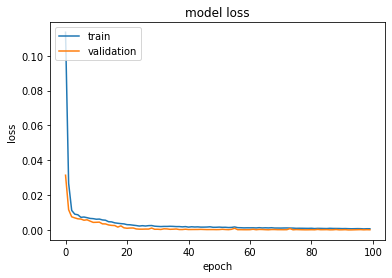

Evaluation metrics
Training Data - MSE Loss: 0.00014627, MAE Loss: 0.00991924
Validation Data - MSE Loss: 0.00018315, MAE Loss: 0.01113062
Test Data - MSE Loss: 0.00012154, MAE Loss: 0.00915406


In [ ]:
plot_loss(history)

print_metrics_model(X_train, y_train, X_val, y_val, X_test, y_test)

In [ ]:
# Visualize the results
def plot_predictions_test(y_test, predictions):
    plt.plot(np.arange(len(y_test)),y_test, color = 'red', label = 'Real')
    plt.plot(np.arange(len(predictions)),predictions, color = 'green', label = 'Predicted')
    plt.xticks(np.arange(0,len(predictions),10))
    plt.title('Mackey-glass Prediction')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return

(180, 1)


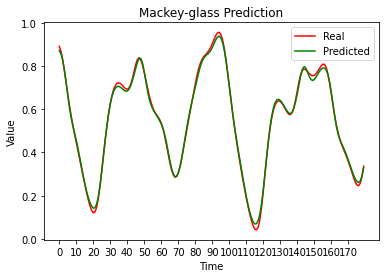

In [ ]:
predictions = model.predict(X_test)
print(predictions.shape)

plot_predictions_test(y_test.squeeze(), predictions)

In [ ]:
print('Real mse on test', mean_squared_error(y_test.squeeze(),predictions))

Real mse on test 0.00012153813578772028


## 2.3 1-D CNN model for 1-step ahead forecasting
**CNNs** and more specifically 2D Convolutions, are traditionally used for processing and learning features of images. For the last years though, there has been a huge number of successes in **applying convolutions to 1D data**, such as in natural language processing tasks, audio etc. In these cases 1D Convolutions can be used as alternatives to traditional recurrent neural networks (RNNs) such as LSTMs and GRUs. Unlike RNNs, they can be run in parallel for really fast computations.

For applying temporal convolutions we can use layer [**Conv1D from keras**](https://keras.io/api/layers/convolution_layers/convolution1d/). This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs. To apply this layer to our input with shape (seq_len, features_dimension) we need to define:
- filters: integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
- kernel_size: an integer or tuple/list of a single integer, specifying the length of the 1D convolution window.

The 1D convolutional layer is followed by a [**Max Pooling 1D layer**](https://keras.io/api/layers/pooling_layers/max_pooling1d/) and a Dense layer with 'relu' activation. We finally add a Dense layer to produce the output. Max pooling operation for 1D temporal data downsamples the input representation by taking the maximum value over the window defined by pool_size. Max pooling is a pooling operation that selects the maximum element from the region of the feature map covered by the filter. Thus, the output after max-pooling layer would be a feature map containing the most prominent features.

![1D_CNN.png](https://am3pap003files.storage.live.com/y4mF-xwl5WwWIPXqvj5o_NxZn2Ir4glSM46WQMnwLVtx5RaJVfjnr3a5tPsxxYjl_e0nCjPdVRlcBoygIiC_XeEWbB2WypWuh-Ot1hiZO7eccWyug_MonjpZM4FxFGR1cetPKH-1I7A4emItKsRO7uYrxRHl6n5Jt4rxK5Qn4z26sZf5UDIlMM9ckBJgLSLy_ea?width=395&height=363&cropmode=none)

*Your task is to add a Conv1D layer + MaxPooling + Flatten + Dense for 1-step forecasting in create_model_cnn below.*

In [ ]:
keras.backend.clear_session()
seed(100)
tf.random.set_seed(100)

def create_model_cnn(seq_len, features_dimension):
    # Fill your code here
    in_seq = Input(shape=(seq_len, features_dimension))
    x = Conv1D(filters=16, kernel_size=2, activation='relu')(in_seq)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(units=32, activation='relu')(x)
    out = Dense(units = 1)(x)
    model = Model(inputs=in_seq, outputs=out)
    return model

In [ ]:
model = create_model_cnn(np.shape(X_train)[1], np.shape(X_train)[2])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 19, 16)            48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 16)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                                 
 dense (Dense)               (None, 32)                4640      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                             

In [ ]:
history = compile_and_fit(model, X_train, y_train, X_val, y_val, patience=10)

Epoch 1/100
50/50 [==============================] - 1s 5ms/step - loss: 0.1185 - mean_absolute_error: 0.2785 - val_loss: 0.0469 - val_mean_absolute_error: 0.1868
Epoch 2/100
50/50 [==============================] - 0s 3ms/step - loss: 0.0267 - mean_absolute_error: 0.1418 - val_loss: 0.0135 - val_mean_absolute_error: 0.1022
Epoch 3/100
50/50 [==============================] - 0s 3ms/step - loss: 0.0079 - mean_absolute_error: 0.0776 - val_loss: 0.0068 - val_mean_absolute_error: 0.0703
Epoch 4/100
50/50 [==============================] - 0s 3ms/step - loss: 0.0044 - mean_absolute_error: 0.0562 - val_loss: 0.0046 - val_mean_absolute_error: 0.0553
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0030 - mean_absolute_error: 0.0440 - val_loss: 0.0037 - val_mean_absolute_error: 0.0462
Epoch 6/100
50/50 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_absolute_error: 0.0383 - val_loss: 0.0032 - val_mean_absolute_error: 0.0406
Epoch 7/100
50/50 [===

In [ ]:
print_metrics_model(X_train, y_train, X_val, y_val, X_test, y_test)

Evaluation metrics
Training Data - MSE Loss: 0.00007175, MAE Loss: 0.00646017
Validation Data - MSE Loss: 0.00008679, MAE Loss: 0.00703939
Test Data - MSE Loss: 0.00007562, MAE Loss: 0.00657841


(180, 1)


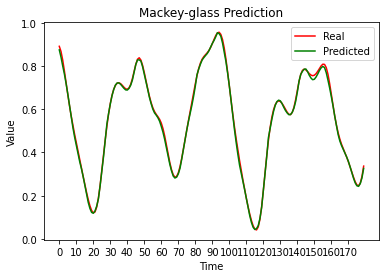

In [ ]:
predictions = model.predict(X_test)
print(predictions.shape)

plot_predictions_test(y_test.squeeze(), predictions)

In [ ]:
print('Real mse on test', mean_squared_error(y_test.squeeze(),predictions))

Real mse on test 7.561715651902187e-05


## 2.4 Seq2Seq LSTM for multi-step ahead forecasting


We **repeat part 2.1.4** to produce the train, validation and test datasets for multi-step forecasting, using a fixed horizon $\tau_{max}$.

*Your task is to call the function create_supervised_data() separately for train, validation and test sets to produce inputs and targets for multi-step ahead forecasting*.

In [ ]:
# Set the desirable history for creating samples from the time-series
seq_len = 64
ahead = 64

# Fill your code here
X_train_multi, y_train_multi = create_supervised_data(train_data, seq_len=seq_len, ahead=ahead)
print('X_train shape is ', np.shape(X_train_multi))
print('y_train shape is ', np.shape(y_train_multi))

X_val_multi, y_val_multi = create_supervised_data(val_data, seq_len=seq_len, ahead=ahead)
print('X_val shape is ', np.shape(X_val_multi))
print('y_val shape is ', np.shape(y_val_multi))

X_test_multi, y_test_multi = create_supervised_data(test_data, seq_len=seq_len, ahead=ahead)
print('X_test shape is ', np.shape(X_test_multi))
print('y_test shape is ', np.shape(y_test_multi))

X_train shape is  (1473, 64, 1)
y_train shape is  (1473, 64, 1)
X_val shape is  (73, 64, 1)
y_val shape is  (73, 64, 1)
X_test shape is  (73, 64, 1)
y_test shape is  (73, 64, 1)


In the next cell we will create an encoder-decoder architecture with LSTMs as building blocks, to forecast many steps ahead. **Direct methods** for multi-horizon forecasting produce forecasts directly using all available inputs (historical information). They typically make use of **sequence-to-sequence architectures**, using an encoder to summarise past information (i.e. targets, observed inputs and a priori known inputs), and a decoder to combine them with known future inputs. An alternative approach is to use simpler models to directly **produce a fixed-length vector** matching the desired forecast horizon (which we'll use in paragraph 2.5). The direct approach, does require the specification of a maximum forecast horizon (i.e. $\tau_{max}$), with predictions made only at the predefined discrete intervals. On the other hand, **iterative approaches** to multi-horizon forecasting typically make use of **autoregressive deep learning architectures** – producing multi-horizon forecasts by recursively feeding samples of the target into future time steps. As autoregressive models are trained in the exact same fashion as one-step-ahead prediction models, the iterative approach allows for the easy generalisation of standard models to multi-step forecasting. However, as a small amount of error is produced at each time step, the recursive structure of iterative methods can potentially lead to large error accumulations over longer forecasting horizons.

For simplicity we'll implement direct forecasting. The desired architecture is presented in the following figure and includes an encoder and a decoder with LSTM layers.
![Seq2seq](https://am3pap003files.storage.live.com/y4mFW-T_gXX72ZAxiaXWyxOSOngIezWGTk_3nXmsxesCWgMADC2yZm0-ivYICg6uh54AZQcTW4BetJUJhMno1iRjOFxPwzSNoAtQfjrdQmLkRulAryVVJQp-6gWgsh3JGoVMg9tq1i3PCokyX-UQfxLjMy23eCwsjEENvzJMjC4PI_uxYTUopAcKl9klRM6_Zwp?width=1355&height=335&cropmode=none)

*Your task is to add write the seq2seq architecture for multi-step forecasting in create_lstm_enc_dec below.*

In [ ]:
keras.backend.clear_session()
seed(100)
tf.random.set_seed(100)

def create_lstm_enc_dec(seq_len, features_dimension, ahead):
    # Fill your code here
    # Encoder part
    in_seq = Input(shape=(seq_len, features_dimension))
    encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(50, dropout=0.2, 
                                                            recurrent_dropout=0.2, return_sequences=False, 
                                                            return_state=True)(in_seq)
    decoder = keras.layers.RepeatVector(ahead)(encoder_last_h1)
    decoder = LSTM(50, dropout=0.2, recurrent_dropout=0.2, 
                   return_state=False, 
                   return_sequences=True)(decoder, initial_state=[encoder_last_h2, encoder_last_c])
    out = keras.layers.TimeDistributed(Dense(1))(decoder)

    model = Model(inputs=in_seq, outputs=out)
    # Decoder part
    return model

In [ ]:
model = create_lstm_enc_dec(np.shape(X_train_multi)[1], np.shape(X_train_multi)[2], ahead)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 50),         10400       ['input_1[0][0]']                
                                 (None, 50),                                                      
                                 (None, 50)]                                                      
                                                                                                  
 repeat_vector (RepeatVector)   (None, 64, 50)       0           ['lstm[0][0]']                   
                                                                                              

In [ ]:
history = compile_and_fit(model, X_train_multi, y_train_multi, X_val_multi, y_val_multi, patience=10)

Epoch 1/100
47/47 [==============================] - 13s 158ms/step - loss: 0.1086 - mean_absolute_error: 0.2688 - val_loss: 0.0576 - val_mean_absolute_error: 0.1964
Epoch 2/100
47/47 [==============================] - 7s 145ms/step - loss: 0.0596 - mean_absolute_error: 0.2054 - val_loss: 0.0548 - val_mean_absolute_error: 0.1927
Epoch 3/100
47/47 [==============================] - 7s 147ms/step - loss: 0.0582 - mean_absolute_error: 0.2032 - val_loss: 0.0551 - val_mean_absolute_error: 0.1923
Epoch 4/100
47/47 [==============================] - 7s 146ms/step - loss: 0.0577 - mean_absolute_error: 0.2026 - val_loss: 0.0531 - val_mean_absolute_error: 0.1881
Epoch 5/100
47/47 [==============================] - 7s 144ms/step - loss: 0.0562 - mean_absolute_error: 0.1991 - val_loss: 0.0519 - val_mean_absolute_error: 0.1846
Epoch 6/100
47/47 [==============================] - 7s 147ms/step - loss: 0.0446 - mean_absolute_error: 0.1718 - val_loss: 0.0280 - val_mean_absolute_error: 0.1271
Epoch 7/1

In [ ]:
print_metrics_model(X_train_multi, y_train_multi, X_val_multi, y_val_multi, X_test_multi, y_test_multi)

Evaluation metrics
Training Data - MSE Loss: 0.00573889, MAE Loss: 0.05951416
Validation Data - MSE Loss: 0.01095787, MAE Loss: 0.08754697
Test Data - MSE Loss: 0.00544919, MAE Loss: 0.05699870


In [ ]:
predictions = model.predict(X_test_multi)
print(predictions.shape)

(73, 64, 1)


In [ ]:
def plot_multi_step_forecasts(X_test, y_test, predictions, ncols=4, nrows=3):
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,6), dpi=150)
    for i, ax in enumerate(axes.flat):
        plot_idx = np.random.choice(np.arange(0, len(predictions)))
        
        if len(np.shape(predictions))==3:
            y_pred = predictions[plot_idx,:,:].squeeze()
        else:
             y_pred = predictions[plot_idx,:]
        y_true = np.concatenate([X_test[plot_idx,:,:].squeeze(), y_test[plot_idx,:,:].squeeze()])
        y_pred = np.concatenate([X_test[plot_idx,:,:].squeeze(), y_pred])

        ax.plot(y_pred, color='red', label='preds')
        ax.plot(y_true, color='green', label='true')
        ax.vlines(np.shape(X_test)[1]-1, np.min(y_true), np.max(y_true), color='black', linestyle='dashed')
        ax.legend()

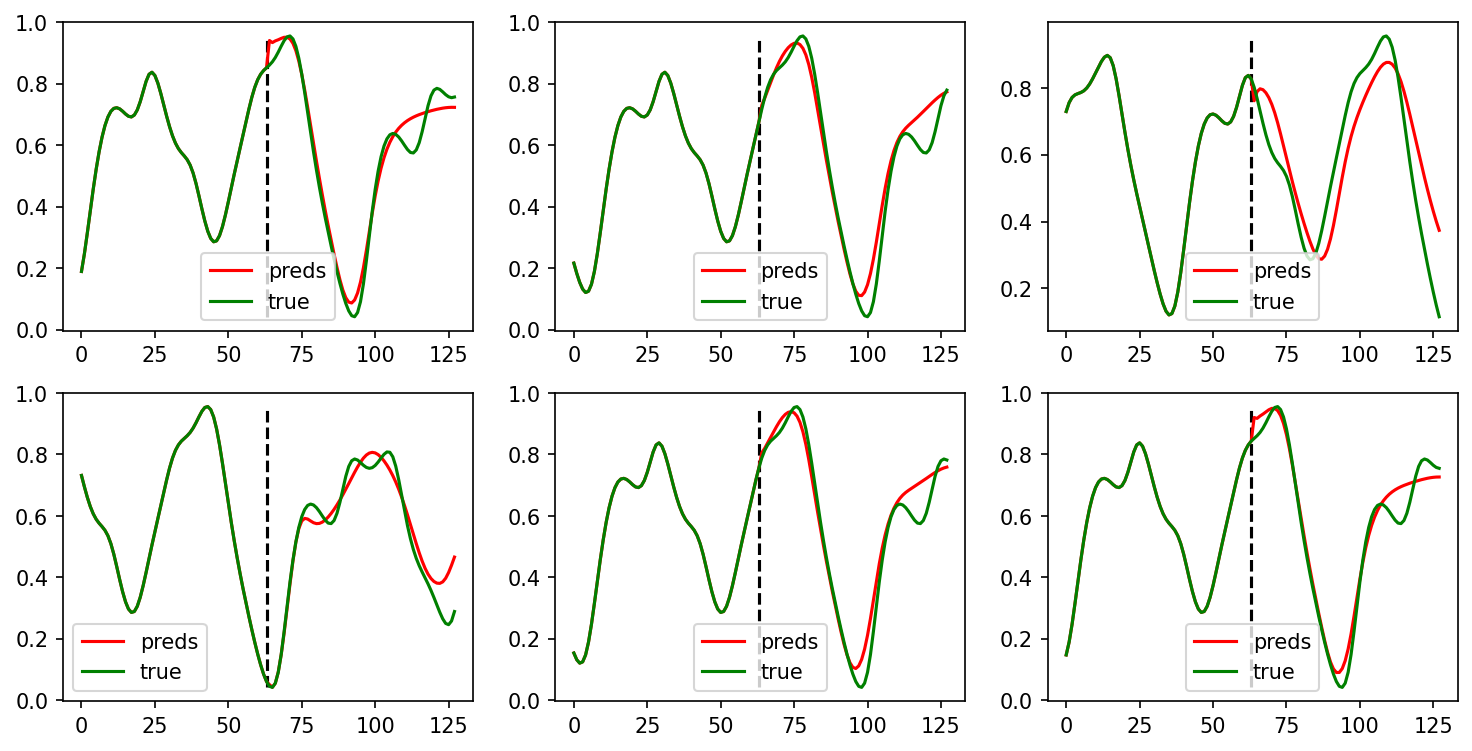

In [ ]:
plot_multi_step_forecasts(X_test_multi, y_test_multi, predictions, 3, 2)

## 2.5 Dilated CNNs for multi-step ahead forecasting (predicting a vector output)

We will try to create a simple architecture inspired by a simplified version of the **WaveNet model**, from [***WaveNet: A Generative Model for Raw Audio, OOrd et al., Sep. 2016***](https://arxiv.org/pdf/1609.03499.pdf). This idea can be applied to any time series forecasting problem, providing a different structure for capturing long-term dependencies and minimizing the excessive number of learnable weights for traditional CNNs.

The core building block of the wavenet model is the dilated causal convolution layer. It utilizes some other key techniques like gated activations and skip connections, but for in this lab we'll focus on the central idea of the architecture for simplicity. 

**Causal Convolutions**

In the simple [1-dimensional convolution layer](https://keras.io/api/layers/pooling_layers/max_pooling1d/) (as shown earlier), a filter of weights slides across the input series, covering all the regions of the series (usually with overlapping). The shape of the output depends on the sequence padding used, and is closely related to the connection structure between inputs and outputs. For instance, a filter of width 2, stride of 1, and no padding means that the output sequence will have one fewer entry than the input. We can adjust our convolution layers to explicitly prohibit the future from influencing the past. In other words, we only allow inputs to connect to future time step outputs in a causal structure. In practice, this causal 1D structure is easy to implement by shifting traditional convolutional outputs by a number of timesteps. Keras achieves it by setting **padding = 'causal'**.

**Dilated (Causal) Convolutions**

With causal convolutions we have the proper tool for handling temporal flow, but we need an additional modification to properly handle long-term dependencies. In fact, we can add additional layers per time-step to reach further back in the series, so as to increase the output's receptive field.

Using simple convolutios to model the long history of a series, make our model way too computationally and statistically complex. WaveNet uses **dilated convolutions, which allow the receptive field to increase exponentially** as a function of the number of convolutional layers. In a dilated convolution layer, filters are not applied to inputs in a simple sequential manner, but instead skip a constant dilation rate inputs in between each of the inputs they process, as shown in the pricture above. By increasing the dilation rate multiplicatively at each layer (e.g. 1, 2, 4, 8, ...), we can achieve the exponential relationship between the number of layer and receptive field size that we desire. 

![TCN](https://am3pap003files.storage.live.com/y4mxOC8fkKkQ8B_bOjIfdafK88eeDnxIEN25KgyLNBe4kGpXRCMNFtE_KyUSW3G8iOtGk0Yjj4Moipvj3JOoezGhp2ubIzyLNjZ9bjskXy0YuZbZDr9yMY2WJFA5KPr2uaAzQ32y5-tx4zchE-bsPxMEemzoWT-7r_WaJAaGDZOa9mIwj5A7NS3TQXNuyTbxGYb?width=1422&height=522&cropmode=none)

In the following cell we stack dilated convolutions of different dilation rates, followed by a Flatten and a Dense layer in order to get the final prediction. The convolutional layers that encode past information are then followed by a dense layer that learns directly a fixed size vector output that corresponds to the forecasting horizon.

*Your task is to add stacked Conv1D layers with a kernel size of 2 in order to achieve the receptive for the given history length, followed by a Dense layer for the final multi-step ahead predictions.*

In [ ]:
keras.backend.clear_session()
seed(100)
tf.random.set_seed(100)

def create_model_dilated_cnn(seq_len, features_dimension, ahead):
    # Fill your code here
    model = Sequential()
    # Create a for loop to stack Conv1d layers and pass the dilation rates from a list
    
    return model

In [ ]:
model = create_model_dilated_cnn(np.shape(X_train_multi)[1], np.shape(X_train_multi)[2], ahead)
model.summary()

In [ ]:
history = compile_and_fit(model, X_train_multi, y_train_multi, X_val_multi, y_val_multi, patience=10)

In [ ]:
print_metrics_model(X_train_multi, y_train_multi, X_val_multi, y_val_multi, X_test_multi, y_test_multi)

In [ ]:
predictions = model.predict(X_test_multi)
print(predictions.shape)

plot_multi_step_forecasts(X_test_multi, y_test_multi, predictions, 3, 2)

### Our Conclusions on deep learning models for forecasting:
- There are several architectures that are promising, with mechanisms that try to extract patterns and remember behaviours from the past.
- Generally is easy for models to capture the general trends and values, but they struggle to learn more fine-grained changes. 
- DL models need the creation of samples and datasets. This can automatically be done with [generators for time-series](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator), or you can apply the functions that we created here (such as the function create_supervised_data). 
- You may need to explore the effect of different transformations to your data (such as Scaling or even differencing and log transformations). Generally our purpose in DL is to minimize feature engineering and data-driven approaches.
- An important factor is the number of time-steps to look back, when creating samples, or the history that you take for your predictions. This is a parameter with which you have to do experiments, but generally we are aiming in using architectures that are able to learn as many time-steps back as possible, in an efficient way.
- Apart from the traditional LSTMs, CNNs with some variations can memorize the past. They also achieve faster training and can learn with less parameters. This helps in working with larger datasets/history to look back and minimizes memory and time constraints in training.
- An import factor is the optimization of the hyperparameters of the DL architectures. There are several libraries for tuning, such as the [keras tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner), which can help you run experiments for different combinations of hyperparameters and select those that best fit your dataset.
- Other important aspects to explore in time-series forecasting are:
    - Multi-step forecasting using autoregressive models (iterative decoding apart from direct methods such as seq2seq and vector output)
    - Attention layers with LSTMs (inspired by models for NLP)
    - Other hybrid models